## Tweets disaster


In [224]:
import pandas as pd
import numpy as np
import missingno as msno
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [225]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [226]:
train = pd.read_csv('/content/drive/MyDrive/nlp_tweets_disaster/train_disaster.csv',encoding='utf-8')
test = pd.read_csv('/content/drive/MyDrive/nlp_tweets_disaster/test_disaster.csv',encoding='utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/nlp_tweets_disaster/sample_submission_disaster.csv',encoding='utf-8')

In [199]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [200]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


### 전처리
### 데이터 결측치 확인

In [227]:
#location column은 삭제
train.drop(columns = 'location', inplace = True)
test.drop(columns = 'location', inplace = True)

In [177]:
train

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,Police investigating after an e-bike collided ...,1


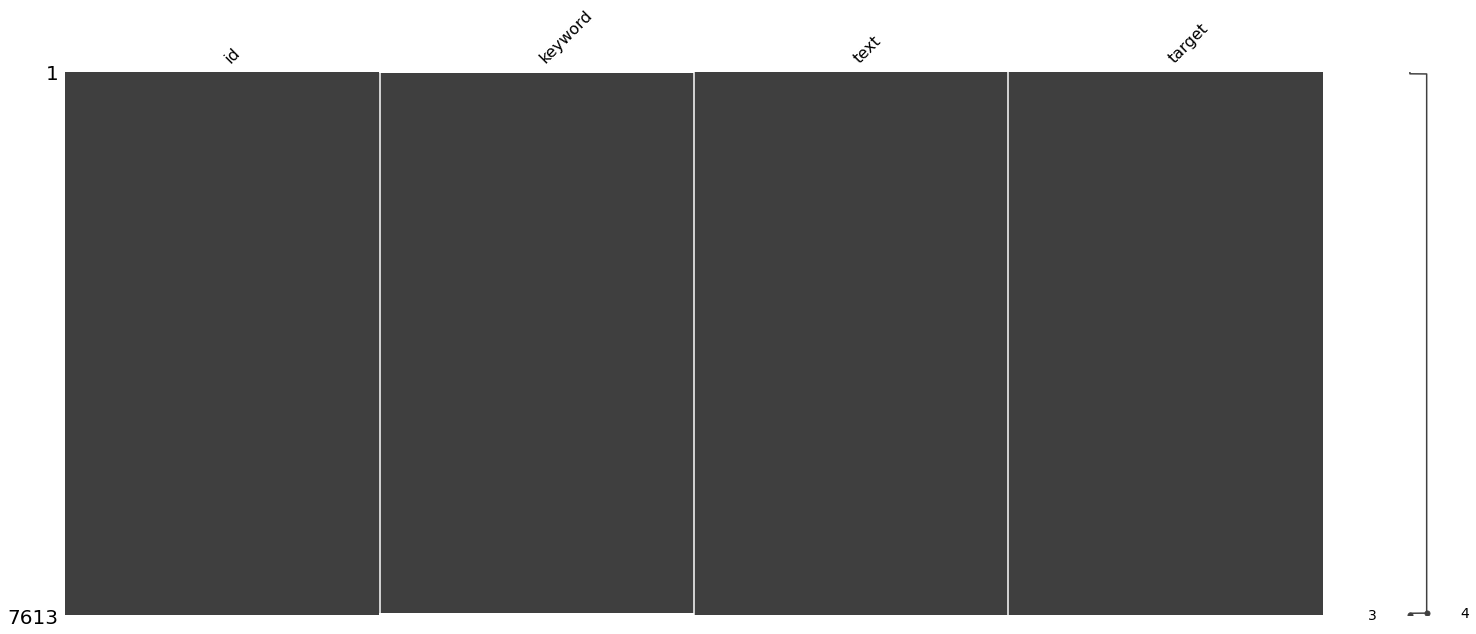

In [202]:
msno.matrix(train)
plt.show()


In [228]:
#결측치 확인(keyword)
train['keyword'].isnull().sum(), test['keyword'].isnull().sum() # (61,26) dataset에서 작은 값이므로 keyword 없으면 drop

(61, 26)

### Text 전처리

In [229]:
from nltk.corpus import stopwords
import nltk

In [204]:
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [205]:
eng_stopwords.append("im")

In [230]:
#url 주소 tweets 제거
def url_remove(text):
  tag = re.compile('[http]\S*')
  return re.sub(tag,'',text)

#@로 시작되는 tag 제거
def tag_remove(text):
  tag = re.compile('[@]\w*')
  return re.sub(tag,'',text)

#불용어 제거
def remove_stopwords(text):
    removed_text = []
    for i in text.split():
        if i.strip().lower() not in eng_stopwords:
            removed_text.append(i.strip())
    return " ".join(removed_text)

#특수기호 제거
def alpha_num(text):
    return re.sub(r'[^a-zA-Z0-9 ]', '', text)


In [231]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(url_remove).apply(tag_remove).apply(remove_stopwords).apply(alpha_num)
test['text'] = test['text'].apply(url_remove).apply(tag_remove).apply(remove_stopwords).apply(alpha_num)

### 데이터 분포 확인

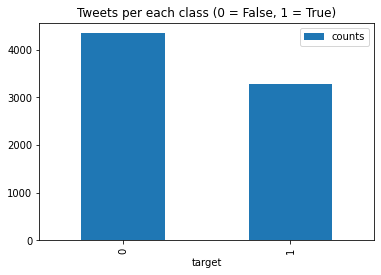

In [232]:
#진성, 가성 tweets 분포 확인
train.groupby(train.target).size().reset_index(name="counts").plot.bar(x='target',title="Tweets per each class (0 = False, 1 = True)")

In [209]:
# 문장 길이 분포도 확인(불용어 제외 단어수)
df = pd.concat([train, test], axis = 0)
df['doc_len'] = df.text.apply(lambda words: len(words.split()))


In [210]:
# 99% 기준으로 추후 데이터 학습에 사용하려 했으나, max 값이 별로 크지 않아 max 값 사용
percent =[0.25,0.5,0.75,0.99]
df['doc_len'].describe(percentiles = percent)


count    10876.000000
mean         7.584314
std          3.370046
min          0.000000
25%          5.000000
50%          7.000000
75%         10.000000
99%         16.000000
max         22.000000
Name: doc_len, dtype: float64

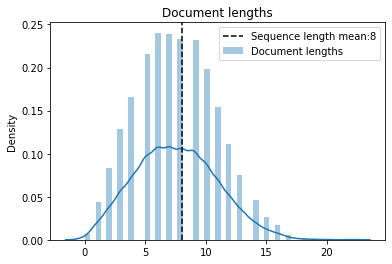

 가장 긴 문장은 22 개의 단어를, 가장 짧은 문장은 0 개의 단어를 가지고 있습니다.


In [211]:
def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {df['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {df['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(df)

## Token화 및 정수 인코딩

In [241]:
def tokenizer(doc):
    result = []
    tknzr = TreebankWordTokenizer()
    tks = tknzr.tokenize(doc)
    for tk in tks:
        result.append(tk)
    return result

In [242]:
from tensorflow.keras.preprocessing.text import Tokenizer

#Token화

df["tokenized_text"]=df['text'].apply(tokenizer)
df

,id,keyword,text,target,doc_len,tokenized_text,encoded_text,padded
0,1,NaN,deeds reason ear may alla forgive us,1.0,7,"[deeds, reason, ear, may, alla, forgive, us]","[3491, 574, 105, 58, 1152, 2385, 27]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,4,NaN,fores fire near la ronge sask canada,1.0,7,"[fores, fire, near, la, ronge, sask, canada]","[106, 13, 160, 42, 4934, 4935, 980]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,5,NaN,residen asked s officers evacua orders ex,1.0,7,"[residen, asked, s, officers, evacua, orders, ex]","[728, 1044, 47, 1231, 43, 1153, 12]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,6,NaN,13000 receive wildfires evacua orders california,1.0,6,"[13000, receive, wildfires, evacua, orders, ca...","[2071, 2793, 884, 43, 1153, 55]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,7,NaN,jus go sen ruby alaska smoke wildfires sc,1.0,8,"[jus, go, sen, ruby, alaska, smoke, wildfires,...","[7, 15, 708, 3492, 1828, 209, 884, 84]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7,..."
...,...,...,...,...,...,...,...,...
3258,10861,NaN,ear safe los angeles safe fas xrwn,NaN,7,"[ear, safe, los, angeles, safe, fas, xrwn]","[105, 419, 482, 1834, 419, 199, 10799]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3259,10865,NaN,ri worse las ci yard looks like bombed around ...,NaN,11,"[ri, worse, las, ci, yard, looks, like, bombed...","[541, 847, 73, 91, 2187, 219, 6, 380, 243, 374...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 541, 847, 7..."
3260,10868,NaN,green line derailmen c,NaN,4,"[green, line, derailmen, c]","[583, 392, 320, 2]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3261,10874,NaN,meg issues wea ou,NaN,4,"[meg, issues, wea, ou]","[2715, 425, 38, 5]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [235]:
#token 정수 encoding
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokenized_text'])
df['encoded_text'] = tokenizer.texts_to_sequences(df['tokenized_text'])
df

,id,keyword,text,target,doc_len,tokenized_text,encoded_text,padded
0,1,NaN,deeds reason ear may alla forgive us,1.0,7,"[deeds, reason, ear, may, alla, forgive, us]","[3491, 574, 105, 58, 1152, 2385, 27]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,4,NaN,fores fire near la ronge sask canada,1.0,7,"[fores, fire, near, la, ronge, sask, canada]","[106, 13, 160, 42, 4934, 4935, 980]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,5,NaN,residen asked s officers evacua orders ex,1.0,7,"[residen, asked, s, officers, evacua, orders, ex]","[728, 1044, 47, 1231, 43, 1153, 12]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,6,NaN,13000 receive wildfires evacua orders california,1.0,6,"[13000, receive, wildfires, evacua, orders, ca...","[2071, 2793, 884, 43, 1153, 55]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,7,NaN,jus go sen ruby alaska smoke wildfires sc,1.0,8,"[jus, go, sen, ruby, alaska, smoke, wildfires,...","[7, 15, 708, 3492, 1828, 209, 884, 84]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7,..."
...,...,...,...,...,...,...,...,...
3258,10861,NaN,ear safe los angeles safe fas xrwn,NaN,7,"[ear, safe, los, angeles, safe, fas, xrwn]","[105, 419, 482, 1834, 419, 199, 10799]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3259,10865,NaN,ri worse las ci yard looks like bombed around ...,NaN,11,"[ri, worse, las, ci, yard, looks, like, bombed...","[541, 847, 73, 91, 2187, 219, 6, 380, 243, 374...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 541, 847, 7..."
3260,10868,NaN,green line derailmen c,NaN,4,"[green, line, derailmen, c]","[583, 392, 320, 2]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3261,10874,NaN,meg issues wea ou,NaN,4,"[meg, issues, wea, ou]","[2715, 425, 38, 5]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [236]:
#padding, 가장 긴 문장의 길이가 22이 이므로 22로 padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

df['padded'] = df['encoded_text'].apply(lambda x: pad_sequences([x], padding='pre', maxlen=22))
df

,id,keyword,text,target,doc_len,tokenized_text,encoded_text,padded
0,1,NaN,deeds reason ear may alla forgive us,1.0,7,"[deeds, reason, ear, may, alla, forgive, us]","[3491, 574, 105, 58, 1152, 2385, 27]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,4,NaN,fores fire near la ronge sask canada,1.0,7,"[fores, fire, near, la, ronge, sask, canada]","[106, 13, 160, 42, 4934, 4935, 980]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,5,NaN,residen asked s officers evacua orders ex,1.0,7,"[residen, asked, s, officers, evacua, orders, ex]","[728, 1044, 47, 1231, 43, 1153, 12]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,6,NaN,13000 receive wildfires evacua orders california,1.0,6,"[13000, receive, wildfires, evacua, orders, ca...","[2071, 2793, 884, 43, 1153, 55]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,7,NaN,jus go sen ruby alaska smoke wildfires sc,1.0,8,"[jus, go, sen, ruby, alaska, smoke, wildfires,...","[7, 15, 708, 3492, 1828, 209, 884, 84]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7,..."
...,...,...,...,...,...,...,...,...
3258,10861,NaN,ear safe los angeles safe fas xrwn,NaN,7,"[ear, safe, los, angeles, safe, fas, xrwn]","[105, 419, 482, 1834, 419, 199, 10799]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3259,10865,NaN,ri worse las ci yard looks like bombed around ...,NaN,11,"[ri, worse, las, ci, yard, looks, like, bombed...","[541, 847, 73, 91, 2187, 219, 6, 380, 243, 374...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 541, 847, 7..."
3260,10868,NaN,green line derailmen c,NaN,4,"[green, line, derailmen, c]","[583, 392, 320, 2]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3261,10874,NaN,meg issues wea ou,NaN,4,"[meg, issues, wea, ou]","[2715, 425, 38, 5]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [237]:
#훈련용 데이터 생성/keras dataset api 사용
from sklearn.model_selection import train_test_split

train_x = np.stack(df.iloc[:len(train), -1]).astype('float32')
train_y = df.iloc[:len(train), 4]

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, 
                                                  shuffle=True, random_state=0)

test_x = np.stack(df.iloc[len(train):, -1]).astype('float32')
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(10000).batch(128).prefetch(1000)
val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(128).prefetch(1000)

In [238]:
train_x

array([[[0.000e+00, 0.000e+00, 0.000e+00, ..., 4.950e+02, 1.220e+02,
         1.707e+03]],

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 1.500e+02, 2.145e+03,
         1.702e+03]],

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 7.000e+00, 1.500e+01,
         2.650e+02]],

       ...,

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 4.500e+01, 2.223e+03,
         5.801e+03]],

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 3.000e+00, 4.540e+02,
         3.200e+01]],

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.222e+03, 2.300e+02,
         2.150e+02]]], dtype=float32)

## Modeling(Lstm)

Epoch 1/10
51/51 [==============================] - 4s 22ms/step - loss: -9.0297 - accuracy: 0.0186 - val_loss: -32.4816 - val_accuracy: 0.0131
Epoch 2/10
51/51 [==============================] - 0s 10ms/step - loss: -40.5865 - accuracy: 0.0234 - val_loss: -68.1002 - val_accuracy: 0.0131
Epoch 3/10
51/51 [==============================] - 1s 10ms/step - loss: -77.3813 - accuracy: 0.0212 - val_loss: -106.8375 - val_accuracy: 0.0131
Epoch 4/10
51/51 [==============================] - 0s 9ms/step - loss: -115.7026 - accuracy: 0.0228 - val_loss: -147.2444 - val_accuracy: 0.0131
Epoch 5/10
51/51 [==============================] - 1s 10ms/step - loss: -155.8021 - accuracy: 0.0223 - val_loss: -188.8937 - val_accuracy: 0.0131
Epoch 6/10
51/51 [==============================] - 1s 10ms/step - loss: -197.4571 - accuracy: 0.0217 - val_loss: -229.5061 - val_accuracy: 0.0131
Epoch 7/10
51/51 [==============================] - 0s 9ms/step - loss: -239.0982 - accuracy: 0.0213 - val_loss: -267.9876 - 

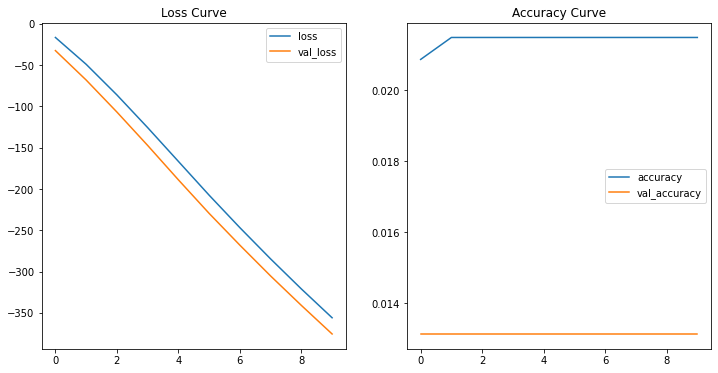

In [240]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(1, 22), activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])


history = model1.fit(train_ds, validation_data=val_ds, epochs=10)

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].legend()
axs[0].set_title('Loss Curve')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
axs[1].legend()
axs[1].set_title('Accuracy Curve')
plt.show()

In [217]:
# Roc curve 기준 overfitting 방지를 위해 epoch = 800 으로 설정
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(1, 22), activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_ds, validation_data=val_ds, epochs=800)

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].legend()
axs[0].set_title('Loss Curve')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
axs[1].legend()
axs[1].set_title('Accuracy Curve')
plt.show()


Epoch 1/800
51/51 [==============================] - 4s 23ms/step - loss: -7.3367 - accuracy: 0.0225 - val_loss: -26.2942 - val_accuracy: 0.0131
Epoch 2/800
51/51 [==============================] - 0s 9ms/step - loss: -34.1671 - accuracy: 0.0212 - val_loss: -60.3729 - val_accuracy: 0.0131
Epoch 3/800
51/51 [==============================] - 0s 10ms/step - loss: -70.2400 - accuracy: 0.0227 - val_loss: -102.2043 - val_accuracy: 0.0131
Epoch 4/800
51/51 [==============================] - 1s 11ms/step - loss: -111.8682 - accuracy: 0.0220 - val_loss: -142.7333 - val_accuracy: 0.0131
Epoch 5/800
51/51 [==============================] - 1s 12ms/step - loss: -151.3053 - accuracy: 0.0223 - val_loss: -181.7688 - val_accuracy: 0.0131
Epoch 6/800
51/51 [==============================] - 1s 10ms/step - loss: -190.9540 - accuracy: 0.0232 - val_loss: -220.9828 - val_accuracy: 0.0131
Epoch 7/800
51/51 [==============================] - 1s 11ms/step - loss: -231.0941 - accuracy: 0.0236 - val_loss: -258

KeyboardInterrupt: ignored

In [ ]:
answer = pd.Series([1 if value >= 0.5 else 0 for value in model.predict(test_x)], name='target')


In [ ]:
submission = pd.concat([test['id'], answer], axis=1)


### keyword 생성(lstm 사용)

In [19]:
# train 데이터와 test 데이터 인덱스 없이 배열로 만들기
X_train_keyword = np.array([x for x in train_keyword['text']])
X_test_keyword = np.array([x for x in test_keyword['text']])
Y_train_keyword = np.array([x for x in train_keyword['keyword']])
Y_test_keyword = np.array([x for x in test_keyword['keyword']])

In [20]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train_keyword) # Tokenizer 에 데이터 실제로 입력
tokenizer.fit_on_texts(X_test_keyword) # Tokenizer 에 데이터 실제로 입력
tokenizer.fit_on_texts(Y_train_keyword) # Tokenizer 에 데이터 실제로 입력
tokenizer.fit_on_texts(Y_test_keyword) # Tokenizer 에 데이터 실제로 입력
sequences_X_train = tokenizer.texts_to_sequences(X_train_keyword)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_X_test = tokenizer.texts_to_sequences(X_test_keyword)      # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_Y_train = tokenizer.texts_to_sequences(Y_train_keyword)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_Y_test = tokenizer.texts_to_sequences(Y_test_keyword)      # 문장 내 모든 단어를 시퀀스 번호로 변환
print(len(sequences_X_train),len(sequences_Y_train), len(sequences_X_test),len(sequences_Y_test))

7552 7552 3237 3237


In [55]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [21]:
# 독립변수 데이터 전처리
  ## 문장의 길이기 제각각이기 때문에 벡터 크기 다 다름
  ## 그러므로 최대 시퀀스 길이 크기(25) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 25    # 위에서 그래프 확인 후 정함
padding_type='post'

train_x = pad_sequences(sequences_X_train, padding=padding_type, maxlen=max_length)
test_x = pad_sequences(sequences_X_test, padding=padding_type, maxlen=max_length)
train_y = pad_sequences(sequences_Y_train, padding=padding_type, maxlen=max_length)
test_y = pad_sequences(sequences_Y_test, padding=padding_type, maxlen=max_length)


print(train_x.shape, train_y.shape,test_x.shape,test_y.shape)

(7552, 25) (7552, 25) (3237, 25) (3237, 25)


In [22]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 25    # 위에서 그래프 확인 후 정함
padding_type='post'

In [24]:
# 양방향 LSTM 레이어를 사용한 모델 (model) 정의
model = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.LSTM(128, input_shape = (1,25)),
        Dense(1, activation='softmax')
    ])
    
model.compile(loss= 'mean_squared_error', 
              optimizer= 'adam',
              metrics = ['accuracy']) 
model.summary()

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 200)           400000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 568,577
Trainable params: 568,577
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2) 

Epoch 1/50
61/61 [==============================] - 12s 156ms/step - loss: 2363.6738 - accuracy: 0.0000e+00 - val_loss: 2284.3633 - val_accuracy: 0.0000e+00
Epoch 2/50
61/61 [==============================] - 9s 144ms/step - loss: 2323.4102 - accuracy: 0.0000e+00 - val_loss: 2284.3633 - val_accuracy: 0.0000e+00
Epoch 3/50
61/61 [==============================] - 8s 139ms/step - loss: 2342.8567 - accuracy: 0.0000e+00 - val_loss: 2284.3633 - val_accuracy: 0.0000e+00
Epoch 4/50
61/61 [==============================] - 8s 137ms/step - loss: 2306.1847 - accuracy: 0.0000e+00 - val_loss: 2284.3633 - val_accuracy: 0.0000e+00
Epoch 5/50
61/61 [==============================] - 8s 134ms/step - loss: 2346.1666 - accuracy: 0.0000e+00 - val_loss: 2284.3633 - val_accuracy: 0.0000e+00
Epoch 6/50
61/61 [==============================] - 8s 131ms/step - loss: 2269.0321 - accuracy: 0.0000e+00 - val_loss: 2284.3633 - val_accuracy: 0.0000e+00
Epoch 7/50
61/61 [==============================] - 8s 138ms/st

KeyError: ignored